In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from datasets import load_dataset
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt

dataset = load_dataset("Amite5h/Eurosat-Datast")

2026-01-31 12:43:51.230881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769863431.444003      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769863431.498506      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769863431.978405      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769863431.978446      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769863431.978449      55 computation_placer.cc:177] computation placer alr

README.md:   0%|          | 0.00/681 [00:00<?, ?B/s]

data/train-00000-of-00001-882f15b29ee0bc(…):   0%|          | 0.00/88.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

In [4]:
print(dataset)
split_ds = dataset['train'].train_test_split(test_size=0.2, seed=42)
test_valid = split_ds['test'].train_test_split(test_size=0.5, seed=42)

train_ds = split_ds['train']
val_ds = test_valid['train']
test_ds = test_valid['test']

labels = train_ds.features['label'].names
print(f"Classes: {labels}")

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [5]:
from transformers import AutoImageProcessor

model_name = "google/vit-base-patch16-224-in21k"
processor = AutoImageProcessor.from_pretrained(model_name, use_fast = True)

#transform to RGB
def transform(examples):
    inputs = processor([x.convert("RGB") for x in examples["image"]], return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs

train_ds = train_ds.with_transform(transform)
val_ds = val_ds.with_transform(transform)
test_ds = test_ds.with_transform(transform)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [7]:
import torch
from transformers import ViTForImageClassification

id2label = {str(i): label for i,label in enumerate(labels)}
label2id = {label: str(i) for i,label in enumerate(labels)}

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments,Trainer
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


args = TrainingArguments(
    output_dir="./vit-eurosat",
    logging_strategy="steps",
    logging_steps=10,
    eval_strategy="epoch",   
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/tmp/ipykernel_55/1267954760.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.228800,0.215354,0.983333
2,0.135500,0.131586,0.985926
3,0.099600,0.112897,0.987778


TrainOutput(global_step=1014, training_loss=0.285551295683699, metrics={'train_runtime': 1510.256, 'train_samples_per_second': 42.907, 'train_steps_per_second': 0.671, 'total_flos': 5.021840974587494e+18, 'train_loss': 0.285551295683699, 'epoch': 3.0})

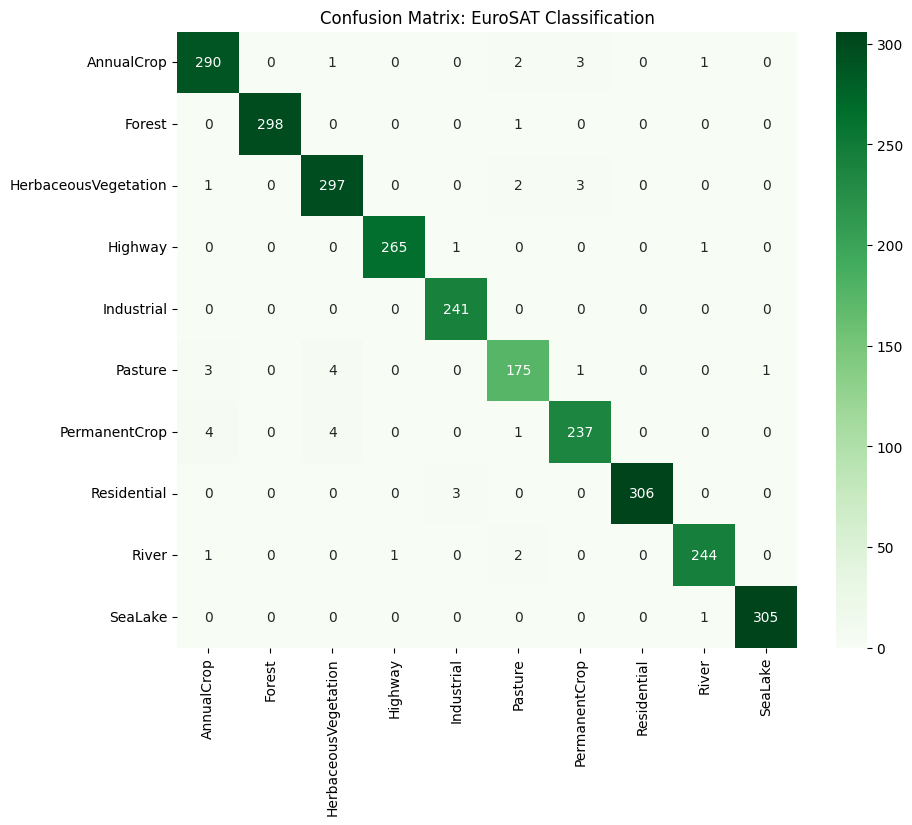

                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.98      0.97       297
              Forest       1.00      1.00      1.00       299
HerbaceousVegetation       0.97      0.98      0.98       303
             Highway       1.00      0.99      0.99       267
          Industrial       0.98      1.00      0.99       241
             Pasture       0.96      0.95      0.95       184
       PermanentCrop       0.97      0.96      0.97       246
         Residential       1.00      0.99      1.00       309
               River       0.99      0.98      0.99       248
             SeaLake       1.00      1.00      1.00       306

            accuracy                           0.98      2700
           macro avg       0.98      0.98      0.98      2700
        weighted avg       0.98      0.98      0.98      2700



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


outputs = trainer.predict(test_ds)
y_pred = np.argmax(outputs.predictions, axis=-1)
y_true = outputs.label_ids

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', 
            xticklabels=labels, yticklabels=labels, cmap='Greens')
plt.title('Confusion Matrix: EuroSAT Classification')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [17]:
trainer.save_model("./final_eurosat_model")
processor.save_pretrained("./final_eurosat_model")

print("Model saved successfully in ./final_eurosat_model")

import shutil

# Zip the folder to make it downloadable from Kaggle's 'Output' section
shutil.make_archive("eurosat_model_v1", 'zip', "./final_eurosat_model")
print("Archive created: eurosat_model_v1.zip")

Model saved successfully in ./final_eurosat_model
Archive created: eurosat_model_v1.zip
